- https://gist.github.com/tommct/1490cdf856d745ba41c1ac99ada2b579

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import cm

import torch
# import torch.nn as nn
# import torch.nn.functional as F
from torchvision import datasets, transforms

# if torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
#     device = torch.device('cpu')
device = torch.device('mps')
# print('Using PyTorch version:', torch.__version__, ' Device:', device)

# Import conditions if we are running in Jupyter vs other...
# https://stackoverflow.com/a/39662359/394430
def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True  # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False  # Probably standard Python interpreter

if is_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

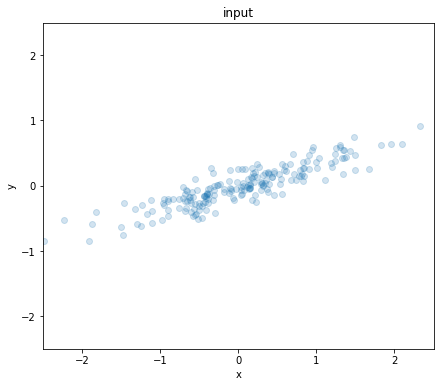

In [3]:
# From https://jakevdp.github.io/PythonDataScienceHandbook/06.00-figure-code.html#Principal-Components-Rotation
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

def project_points(src, tgt, ax=None, color='red'):
    ax = ax or plt.gca()
    src2 = tgt * np.dot(src, tgt) / np.linalg.norm(tgt)
    ax.plot([src[0], src2[0]], [src[1], src2[1]], color=color, lw=.7)

def draw_projection(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=.8,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# plot data
ax.scatter(X[:, 0], X[:, 1], alpha=0.2)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
# ax.axis('equal');
ax.set(xlabel='x', ylabel='y', title='input');

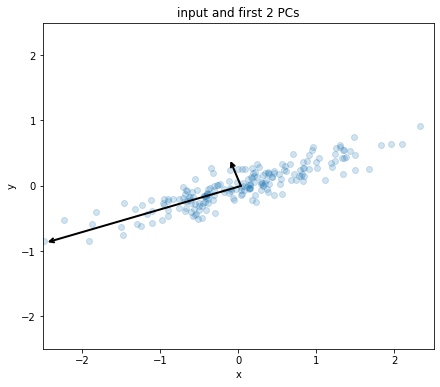

In [4]:
pca = PCA(n_components=2, whiten=True)
pca.fit(X)

# plot data
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set(xlabel='x', ylabel='y', title='input and first 2 PCs');

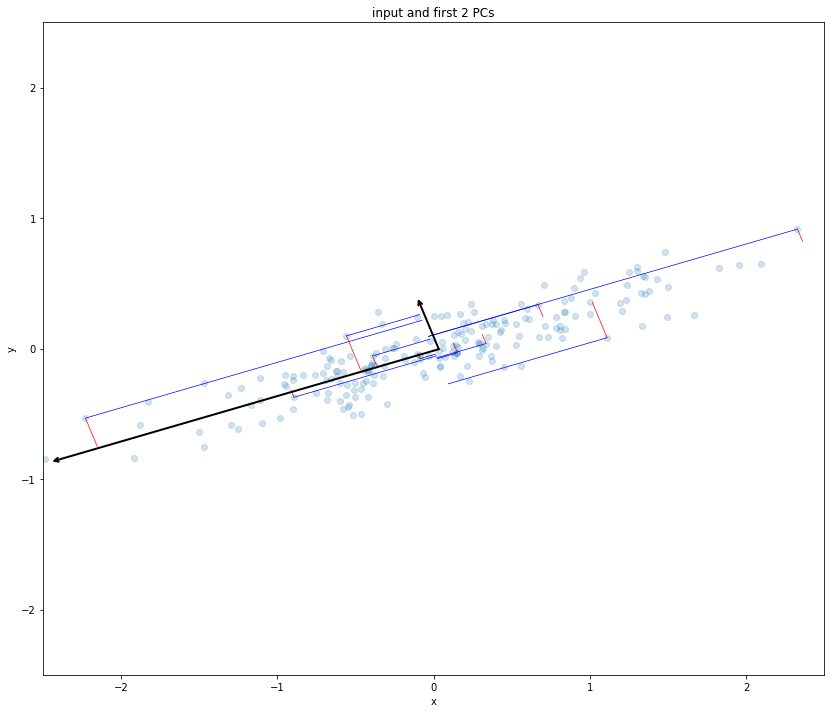

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
ax.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax)

pts = X.copy()
pts = pts[np.argsort( pts[:, 0] ), :] 
pts = pts[1::22]
for pt in pts:
    project_points(pt, pca.components_[0], ax, color='red')
    project_points(pt, pca.components_[1], ax, color='blue')
    
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set(xlabel='x', ylabel='y', title='input and first 2 PCs');

(-3.2, 3.2)

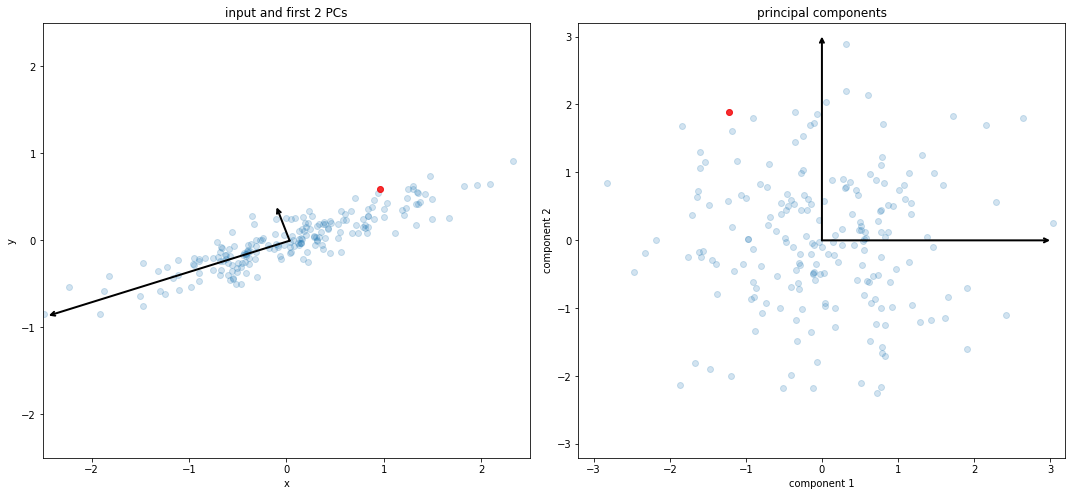

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# plot data
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.2)
ax[0].scatter(X[1, 0], X[1, 1], alpha=0.8, color='red')
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
# ax[0].axis('equal');
ax[0].set(xlabel='x', ylabel='y', title='input')
ax[0].set_xlim(-2.5, 2.5)
ax[0].set_ylim(-2.5, 2.5)
ax[0].set(xlabel='x', ylabel='y', title='input and first 2 PCs');

# plot principal components
X_pca = pca.transform(X)

ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
ax[1].scatter(X_pca[1, 0], X_pca[1, 1], alpha=0.8, color='red')

draw_vector([0, 0], [0, 3], ax=ax[1])
draw_vector([0, 0], [3, 0], ax=ax[1])
# ax[1].axis('equal')
ax[1].set(xlabel='component 1', ylabel='component 2',
          title='principal components',
          xlim=(-5, 5), ylim=(-3, 3.1))
ax[1].set_xlim(-3.2, 3.2)
ax[1].set_ylim(-3.2, 3.2)

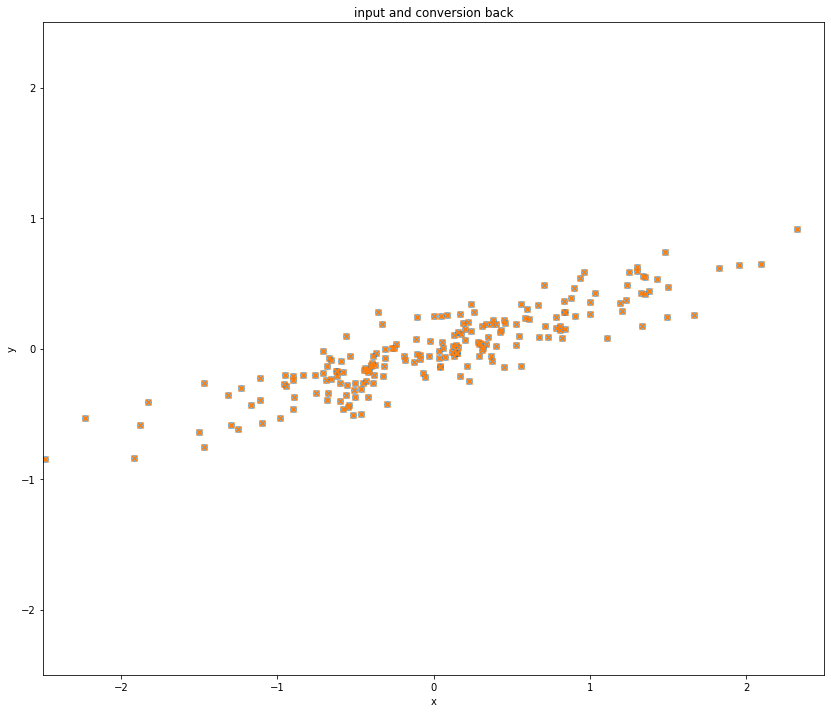

In [7]:
Y = pca.inverse_transform(X_pca)
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
ax.scatter(X[:, 0], X[:, 1], alpha=0.5)
ax.scatter(Y[:, 0], Y[:, 1], alpha=1., marker='x')
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set(xlabel='x', ylabel='y', title='input and conversion back');


In [8]:
print(f'The amount of variance explained by the first PC is {pca.explained_variance_[0]:.3f}')
print(f'The amount of variance explained by the second PC is {pca.explained_variance_[1]:.3f}')
print(f'Total amount of variance explained by the first two PCs is {np.sum(pca.explained_variance_):.3f}')
print(f'Proportional amount of variance explained: {pca.explained_variance_ratio_[0]:.3f}, {pca.explained_variance_ratio_[1]:.3f}')

The amount of variance explained by the first PC is 0.763
The amount of variance explained by the second PC is 0.018
Total amount of variance explained by the first two PCs is 0.781
Proportional amount of variance explained: 0.976, 0.024


In [9]:
cor_x = np.corrcoef(X.T)
print(f'Correlation Matrix:\n {cor_x}')

Correlation Matrix:
 [[1.         0.88938995]
 [0.88938995 1.        ]]


In [11]:
eig_vals, eig_vecs = np.linalg.eig(cor_x)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]

Eigenvalues 
[0.11061005 1.88938995]


In [12]:
# We standardize the data, centering it at zero and balancing.
X_std = StandardScaler().fit_transform(X)

In [13]:
u,s,v = np.linalg.svd(X_std.T)
print(f'Eigenvectors via SVD:\n {u}\n')
print(f'Eigenvalues:\n{s} \n')
print(f'Dot product U^T*U:\n {np.dot(u.T,u)}')

Eigenvectors via SVD:
 [[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]

Eigenvalues:
[19.4390841  4.703404 ] 

Dot product U^T*U:
 [[ 1.00000000e+00 -6.83580866e-17]
 [-6.83580866e-17  1.00000000e+00]]


In [14]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.Compose([
                       transforms.ToTensor(),
#                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_dataset = datasets.MNIST('./data', 
                                    train=False, 
                               transform=transforms.Compose([
                       transforms.ToTensor(),
#                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

images = train_loader.dataset.data.detach().numpy().reshape(-1, 28*28)
print(f'Num training images: {len(images)},\tmin val: {images.min():.3f},\tmax val: {images.max():.3f}')

Num training images: 60000,	min val: 0.000,	max val: 255.000


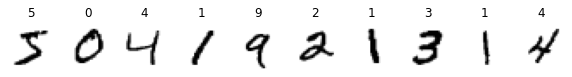

In [15]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize*1.1))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(train_loader.dataset.data[i].numpy().reshape(28,28), cmap="gray_r")
    plt.title(str(train_loader.dataset.targets[i].item()))

In [16]:
%%time
c = np.nan_to_num(np.corrcoef(images.T))  # Normalized [-1, 1] covariance matrix
# c = np.cov(images.T)


CPU times: user 7.47 s, sys: 206 ms, total: 7.67 s
Wall time: 1.44 s


/Users/kunia/opt/anaconda3/envs/detection/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/kunia/opt/anaconda3/envs/detection/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [17]:
c.shape, c.min(), c.max()

((784, 784), -0.43267721957644917, 1.0)

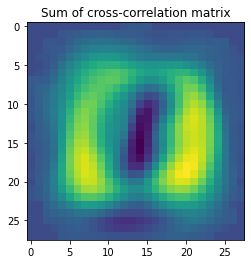

In [18]:
fig = plt.figure()
plt.imshow(c.sum(axis=0).reshape(28,28), interpolation='nearest')
plt.title('Sum of cross-correlation matrix');

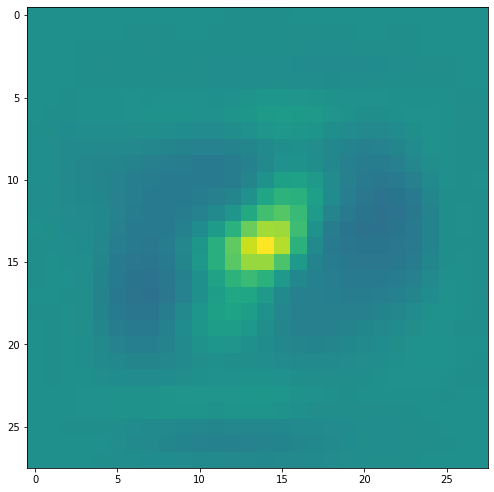

In [19]:
side_dim = 28
data = c.reshape(side_dim, side_dim, side_dim, side_dim)
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([.1, .1, .8, .8])
implot = ax.imshow(data[side_dim>>1, side_dim>>1].reshape(side_dim, side_dim), 
                   interpolation='nearest', clim=(-1,1))
text=ax.text(-.5,-1, "", va="bottom", ha="left")

last_x, last_y = -1, -1

def onmotion(event):
    global last_x
    global last_y
    global data
    global side_dim
    global text
    global implot
    x = int(np.rint(event.xdata))
    y = int(np.rint(event.ydata))
    if last_x != x or last_y != y and x >=0 and y >= 0:
#         plt.cla()  # Try and see if this keeps it from bogging down with more and more interactivity.
        implot.set_array(data[y, x].reshape(side_dim, side_dim))
        last_x = x
        last_y = y
#     tx = 'x=%d, y=%d, xdata=%f, ydata=%f, x=%d, y=%d' % \
#     (event.x, event.y, event.xdata, event.ydata, x, y)
#     text.set_text(tx)

cid = implot.figure.canvas.mpl_connect('motion_notify_event', onmotion)

CPU times: user 25 s, sys: 533 ms, total: 25.5 s
Wall time: 4.45 s


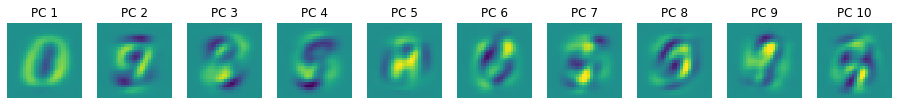

In [20]:
%%time
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(images)
fig = plt.figure(figsize=(n_components*np.power(n_components, 1/5),3))
axes = []
for i in range(n_components):
    ax_ = fig.add_subplot(1, n_components, i+1)
    ax_.imshow(pca.components_[i].reshape(28,28), interpolation='nearest', clim=(-.15, .15));
    ax_.set_title(f'PC {i+1}')
    ax_.axis('off')

    axes.append(ax_)

CPU times: user 48.6 s, sys: 1.41 s, total: 50 s
Wall time: 8.65 s


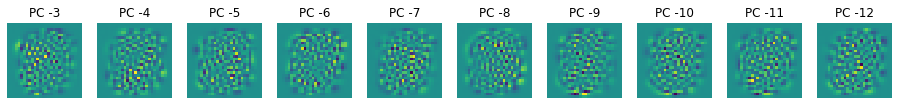

In [21]:
%%time
n_components = 10
pca = PCA(n_components=233)
pca.fit(images)
fig = plt.figure(figsize=(n_components*np.power(n_components, 1/5),3))
axes = []
for i in range(n_components+1, 1, -1):
    ax_ = fig.add_subplot(1, n_components, i-1)
    ax_.imshow(pca.components_[-i].reshape(28,28), interpolation='nearest', clim=(-.15, .15));
    ax_.set_title(f'PC {-i-1}')
    ax_.axis('off')
    axes.append(ax_)

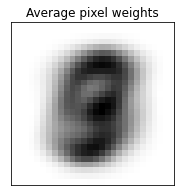

Max of mean: 139.5536


In [22]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.matshow(images.mean(axis=0).reshape(28, 28), cmap = cm.binary)
# ax.plot(pca.mean_)
plt.xticks(np.array([]))
plt.yticks(np.array([]))
plt.title('Average pixel weights')
plt.show()
print("Max of mean:", images.mean(axis=0).max())

In [23]:
# We will apply a Fibonacci sequence for illustrative purposes.
def fib(n):
    a, b = 1, 2  # Normally we'd start at 0, 1, but we don't want that...
    for _ in range(n):
        yield a
        a, b = b, a + b


/var/folders/np/chqdmqld4h98fpysyglct_4m0000gp/T/ipykernel_12631/2161131727.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(fib(n_components), total=n_components):


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

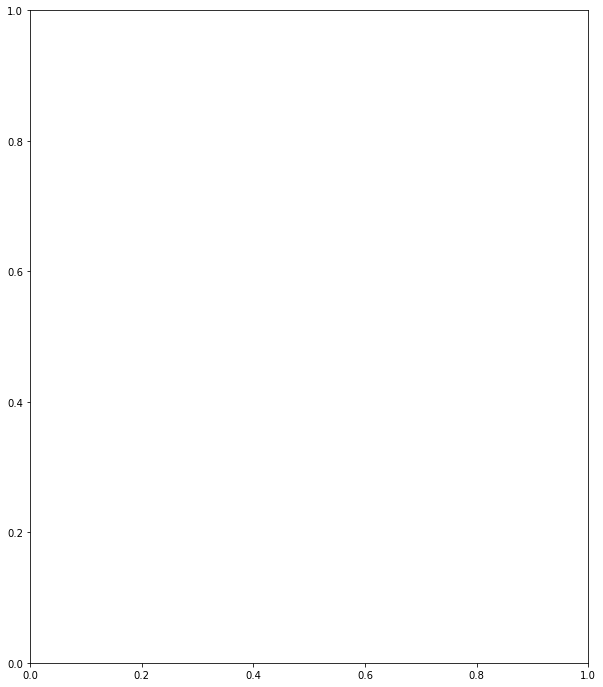

In [24]:
# Try PCA on first ten test images
n_images = 8
n_components = 12
test_images = np.array(test_loader.dataset.data[:n_images].numpy().reshape((n_images,784)))
# Plot the first ten test images and the corresponding outputs
fig = plt.figure(figsize=(10, n_components))
ax = fig.add_subplot(111)
images_in = [test_images[j].reshape(-1, 28) for j in range(n_images)]
image = np.concatenate(images_in, axis=1)

for i in tqdm(fib(n_components), total=n_components):
    pca = PCA(n_components=i)
    pca.fit(images)
    test_outputs = pca.inverse_transform(pca.transform(test_images))
    images_out = [test_outputs[j].reshape(-1, 28) for j in range(n_images)]
    image_out = np.concatenate(images_out, axis=1)
    image = np.concatenate([image, image_out])
ax.matshow(image, cmap = cm.binary)
ax.set_xticks(np.array([]))
y_lim = ax.get_ylim()
y_scale = (y_lim[0] - y_lim[1])/(n_components+1)
ax.set_yticks(np.linspace(.5, n_components+.5, n_components+1) * y_scale)
a = [0]
a.extend(list(fib(n_components)))
ax.set_yticklabels(a)
plt.show()